# Part 1

Use the rate given by equation 2.1 with $r_0 = 50$ Hz and

$$
D(\tau) = -\cos \left( \frac{2 \pi (\tau - 20 \, \text{ms})}{140 \, \text{ms}} \right) \exp \left( -\frac{\tau}{60 \, \text{ms}} \right)
$$

to predict the response of a neuron of the electrosensory lateral-line lobe to a stimulus. The above equation is an approximation for the linear kernel obtained from the spike-triggered average shown in figure 1.9. Use an approximate Gaussian white noise stimulus constructed by choosing a stimulus value every 10 ms ($\Delta t = 10$ ms) from a Gaussian distribution with zero mean and variance $\sigma_s^2 /\Delta t$, with $\sigma_s^2 = 10$. Compute the firing rate over a 10 s period. From the results, compute the firing rate-stimulus correlation function $Q_{rs}(\tau)$. Using equation 2.6, compare $Q_{rs}(-\tau)/\sigma_s^2$ with the kernel $D(\tau)$ given above.

In [19]:
# Import the necessary packages
import matplotlib.pyplot as plt # Plotting
import numpy as np # Maths + stats applications 
import pandas as pd # Handling data
import scipy.signal # A little more niche, very specific maths + stats applications 

# For replicability
np.random.seed(101)

# Exercise 1_1
# Here we will use the equation r_est(t) = r_0 + integral (D (tau) * s(t - tau))

# Initial setup
r_0 = 50 # Hz 
dt = 0.01 # Time step

# The variance of the white noise should be 10/0.01 or 1000
STD_s = np.sqrt(10/dt) # STD of the Gaussian stimulus generator
time_vector = np.arange(0, 10, dt) # Time vector

# Generate the vector of stimuli
s = np.random.normal(0, STD_s, len(time_vector))

# Generature the vector of values for the kernel 
D_list = []
for tau in time_vector:
    D_list.append(-np.cos( (2*np.pi*(tau-0.02))/(0.14)) * np.exp(-tau/0.06))

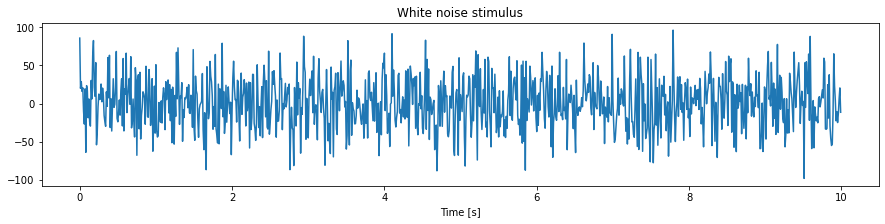

In [20]:
# Make sure we got the stimulus right, it should fluctuate around 0 and for the most part stay within
# the ± square root of 10 (~3.2). It's always a good practice to visualise the inputs! 

plt.figure(figsize=(15, 3))
plt.plot(time_vector, s)
plt.title("White noise stimulus")
plt.xlabel("Time [s]")
plt.show()

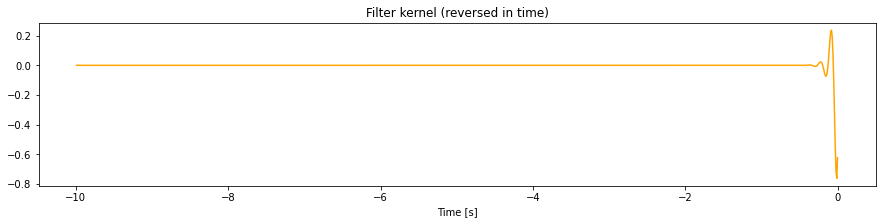

In [21]:
# Here we plot the (reversed) filter kernel in negative time, meaning the stimulus value x many ms before
# the time in question wil affect the firing rate. This effect extends only about 100-200 ms into the past
plt.figure(figsize=(15, 3))
plt.plot(-time_vector[::-1], D_list[::-1], color="orange")
plt.title("Filter kernel (reversed in time)")
plt.xlabel("Time [s]")
plt.show()

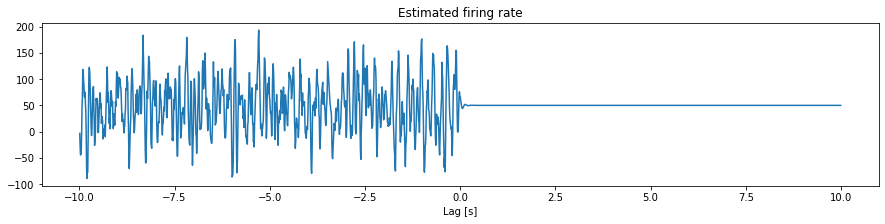

In [22]:
# Perform reverse correlation, add baseline. Convolution is commutative so the order of arguments doesn't 
# matter
convolved_D_s_w_r0 = np.convolve(D_list, s, mode='full') + r_0
lags_RS = np.arange(-len(D_list)+1, len(D_list))*dt 

# Plot the entire convolution as a function of tau
plt.figure(figsize=(15, 3))
plt.plot(lags_RS, convolved_D_s_w_r0)
plt.title("Estimated firing rate")
plt.xlabel("Lag [s]")
plt.show()

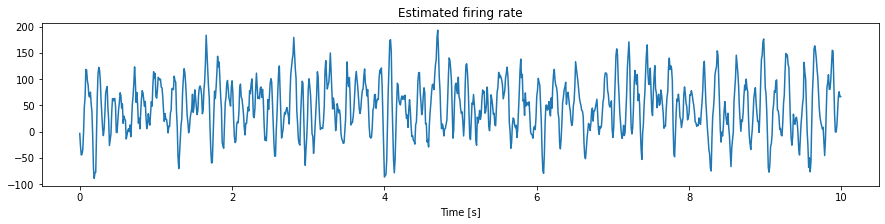

In [23]:
# Only extract meaningful data points, that is, the first half. That is the r_est as a function of time
r_est = convolved_D_s_w_r0[:int(np.ceil(len(convolved_D_s_w_r0)/2))]

plt.figure(figsize=(15, 3))
plt.plot(time_vector, r_est)
plt.title("Estimated firing rate")
plt.xlabel("Time [s]")
plt.show()

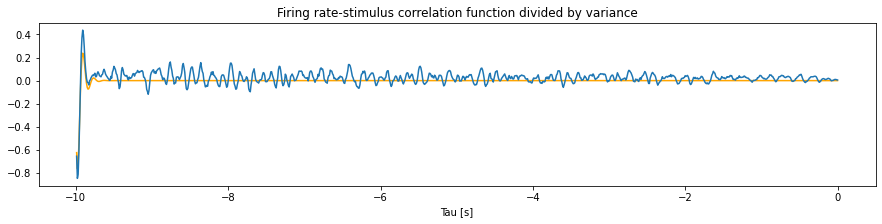

In [24]:
# Empirical firing rate-stimulus correlation function, make sure to divide by the length T
Q_rs_emp = np.correlate(s, r_est, mode='full')/(len(r_est))

# Now we have obtained the cross-correlation Q_rs as a function of tau. We are only interested in the 
# first half of the values though, just like above. Then we mustn't forget to divide by the sigma squared and
# plot it in reverse time 
Q_rs_emp_cor = Q_rs_emp[:int(np.ceil(len(Q_rs_emp)/2))]/STD_s**2

plt.figure(figsize=(15, 3))
plt.plot(-time_vector[::-1], D_list, color="orange")
plt.plot(-time_vector[::-1], Q_rs_emp_cor[::-1])
# plt.plot(time_vector, D_list)
plt.title("Firing rate-stimulus correlation function divided by variance")
plt.xlabel("Tau [s]")
plt.show()

# Part 2

matlab® file c1p8.mat contains the data described in exercise 8 of chapter 1. Use the spike-triggered average (calculated in that exercise) to construct a linear kernel and use it in equation 2.1 to provide a model of the response of the H1 neuron. Choose $r_0$ so that the average firing rate predicted by the model in response to the stimulus used for the data matches the actual average firing rate. Use a Poisson generator with the computed rate to generate a synthetic spike train from this linear estimate of the firing rate in response to the stimulus stim. Plot examples of the actual and synthetic spike trains. How are they similar and how do they differ? Plot the autocorrelation function of the actual and the synthetic spike trains over the range 0 to 100 ms. Why is there a dip at a lag of 2 ms in the autocorrelation of the actual spike train? Is there a dip for the synthetic train too? Plot the interspike interval histogram for both spike trains. Why is there a
dip below 6 ms in the histogram for the actual spike train? What are the coefficients of variation for the two spike trains and why might they differ? (Based on a problem from Sebastian Seung).

In [25]:
# Load the said STA
STA_H1ex8 = np.load("STA_H1ex8.npy")

In [26]:
# Construct a linear kernel, we can use the equation 2.6 from the book wherein the linear kernel is equal 
# to the fraction of the STA multiplied by the average firing rate and divided by the variance of the stimulus.

# The variance (obtained from last chapter) of the white noise stimulus was:
var_s = 5.107

# And the average firing rate was: 
avg_r = 44.66 # Hz

In [27]:
D2 = (STA_H1ex8[0:round(len(STA_H1ex8)/2)] * avg_r) / var_s
D2 = D2[::-1]
D2_tr = D2[0:1000]

In [28]:
# Construct a time vector for plotting 
time_vector2 = np.arange(0, 20*60, 0.002)

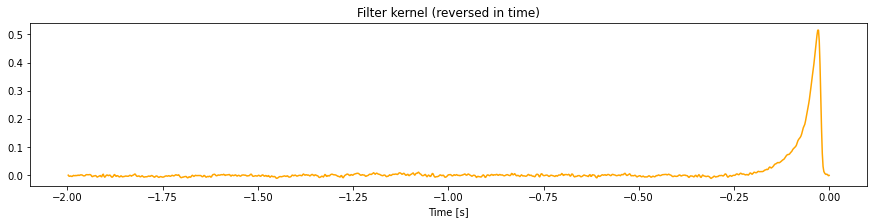

In [29]:
# Here we plot the (reversed) filter kernel in negative time, meaning the stimulus value x many ms before
# the time in question wil affect the firing rate. This effect extends only about 100-200 ms into the past
plt.figure(figsize=(15, 3))
plt.plot(-time_vector2[0:1000][::-1], D2_tr[::-1], color="orange")
plt.title("Filter kernel (reversed in time)")
plt.xlabel("Time [s]")
plt.show()

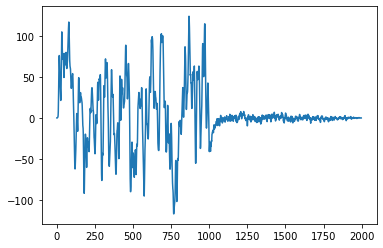

In [30]:
plt.plot(np.convolve(D2_tr, s, mode='full'))
plt.show()

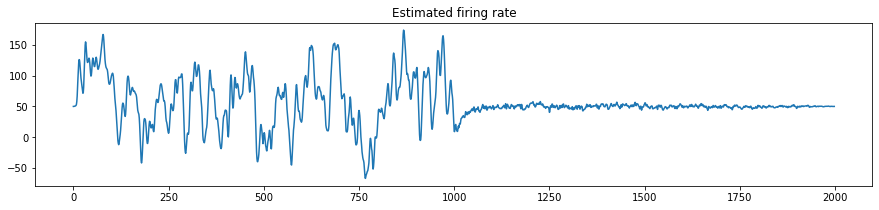

In [31]:
# Perform reverse correlation, add baseline. Convolution is commutative so the order of arguments doesn't 
# matter

dt = 0.002

convolved_D_s_w_r02 = np.convolve(D2_tr, s, mode='full') + r_0
# lags_RS2 = np.arange(-len(convolved_D_s_w_r02)+1, len(convolved_D_s_w_r02))*dt 

# Plot the entire convolution as a function of tau
# fig, ax = plt.subplots()
# ax.xaxis.set_major_locator(MultipleLocator(10))
plt.figure(figsize=(15, 3))
plt.plot(convolved_D_s_w_r02)
plt.title("Estimated firing rate")
# plt.ticklabel_format(axis='both', style='plain', scilimits=(4,4))
# plt.yticks([])
# plt.xlabel("Lag [s]")
plt.show()

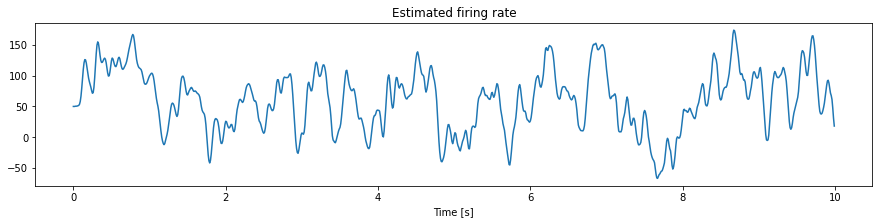

In [32]:
# Only extract meaningful data points, that is, the first half. That is the r_est as a function of time
r_est2 = convolved_D_s_w_r02[:int(np.ceil(len(convolved_D_s_w_r02)/2))]

plt.figure(figsize=(15, 3))
plt.plot(time_vector, r_est2)
plt.title("Estimated firing rate")
plt.xlabel("Time [s]")
plt.show()

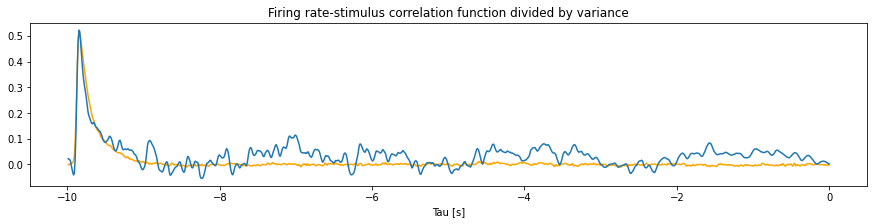

In [34]:
# Empirical firing rate-stimulus correlation function, make sure to divide by the length of trial or T
Q_rs_emp = np.correlate(s, r_est2, mode='full')/(len(r_est2))

# Now we have obtained the cross-correlation Q_rs as a function of tau. We are only interested in the 
# first half of the values though, just like above. Then we mustn't forget to divide by the sigma squared and
# plot it in reverse time 
Q_rs_emp_cor = Q_rs_emp[:int(np.ceil(len(Q_rs_emp)/2))]/STD_s**2

plt.figure(figsize=(15, 3))
plt.plot(-time_vector[::-1], D2_tr, color="orange")
plt.plot(-time_vector[::-1], Q_rs_emp_cor[::-1])
# plt.plot(time_vector, D_list)
plt.title("Firing rate-stimulus correlation function divided by variance")
plt.xlabel("Tau [s]")
plt.show()